In [1]:
# http://course.fast.ai/lessons/lesson3.html
# https://www.kaggle.com/c/state-farm-distracted-driver-detection
# https://github.com/fastai/courses/tree/master/deeplearning1/nbs
#
# If you see the thing below - you're not having cuda and the rest of the libs on the PATH
# (!) ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from utils import *

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


ImportError: cannot import name activity_l2

In [22]:
!cat driver_imgs_list.csv | cut -d, -f1 | sort | uniq | wc -l

27


In [49]:
!pwd

/home/ubuntu/downloads/lesson3


In [114]:
%%bash
split_name='trivial'

rm -rf splits/$split_name
mkdir -p splits/$split_name/train
for obj_type in `ls train`; do
  mkdir -p splits/$split_name/train/$obj_type
  mkdir -p splits/$split_name/valid/$obj_type

  cp -rf train/$obj_type splits/$split_name/train

  for file in `ls splits/$split_name/train/$obj_type | tail -n100`; do
    cp splits/$split_name/train/$obj_type/$file splits/$split_name/valid/$obj_type
    rm splits/$split_name/train/$obj_type/$file
  done
done

In [9]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator()

In [11]:
batch_size=32
train_generator = generator.flow_from_directory(
    'splits/trivial/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')
validation_generator = generator.flow_from_directory(
    'splits/trivial/valid',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 21424 images belonging to 10 classes.
Found 1100 images belonging to 10 classes.


In [137]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD, RMSprop, Adam
vgg = VGG16(weights='imagenet', include_top=True)
fc2 = vgg.get_layer('fc2').output
prediction = Dense(output_dim=10, activation='softmax', name='prediction')(fc2)
model = Model(input=vgg.input, output=prediction)
model.compile(optimizer=Adam(lr=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
for layer in model.layers[-2:]:
    layer.trainable = False

In [138]:
model.fit_generator(train_generator,
                    nb_epoch=1,
                    validation_data=validation_generator,
                    nb_val_samples=200,
                    samples_per_epoch=2000,
                    verbose=True)

Epoch 1/1
2000/2000 [==============================] - 170s - loss: 14.4548 - acc: 0.0980 - val_loss: 14.4133 - val_acc: 0.1058


In [121]:
test_generator = generator.flow_from_directory(
    'test',
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=False,
    class_mode=None)

Found 79726 images belonging to 1 classes.


In [152]:
predictions.shape

(79726, 10)

In [159]:
filenames = map(lambda name: name.split('/')[1], test_generator.filenames)

In [160]:
predictions[0]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [161]:
import pandas as pd

In [186]:
df = pd.DataFrame(predictions,index=filenames)

In [187]:
df.columns = map(lambda (a,b): b + str(a), zip(range(0,10), ['c'] * 10))

In [190]:
df.to_csv('submission.csv', index_label='img')

In [191]:
from IPython.display import FileLink
FileLink('submission.csv')
# this yielded loss of 30.97 vs  loss: 14.4548 - acc: 0.0980 - val_loss: 14.4133 - val_acc: 0.1058

/home/ubuntu/downloads/lesson3/submission.csv

In [12]:
import pandas as pd
drivers = pd.DataFrame.from_csv('driver_imgs_list.csv', index_col=None)

In [15]:
unique_driver_ids = drivers.subject.unique()
len(unique_driver_ids)

26

In [22]:
validation_driver_ids = unique_drivers[:5]

In [97]:
validation_drivers = drivers[drivers.subject.isin(validation_driver_ids)]
float(len(validation_drivers)) / len(drivers), len(validation_drivers), len(drivers)

(0.19519265073135925, 4377, 22424)

In [98]:
%%bash
split_name='unique_drivers'

rm -rf splits/$split_name
mkdir -p splits/$split_name/train
mkdir -p splits/$split_name/valid
for obj_type in `ls train`; do
  mkdir -p splits/$split_name/train/$obj_type
  mkdir -p splits/$split_name/valid/$obj_type

  cp -rf train/$obj_type splits/$split_name/train

  # moving validation to its own set is done below in python
done

In [99]:
split_name='unique_drivers'
from ipywidgets import FloatProgress
from IPython.display import display
import os

num_examples = len(validation_drivers)

progress = FloatProgress(min=0, max=num_examples)
display(progress)

for idx, row in validation_drivers.iterrows():
    file_from = "splits/" + split_name + "/train/" + row['classname'] + "/" + row['img']
    file_to   = "splits/" + split_name + "/valid/" + row['classname'] + "/" + row['img']
    if (os.path.exists(file_from)):
        os.rename(file_from, file_to)
    elif (not os.path.exists(file_to)):
        raise "We've lost " + file_to
    progress.value += 1

print "Done moving {num_examples} examples to validation".format(num_examples=num_examples)

Done moving 4377 examples to validation


In [3]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator()
batch_size=32
train_generator = generator.flow_from_directory(
    'splits/unique_drivers/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')
validation_generator = generator.flow_from_directory(
    'splits/unique_drivers/valid',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 18047 images belonging to 10 classes.
Found 4377 images belonging to 10 classes.


In [1]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense
from keras.models import Model
lr = 0.01
vgg = VGG16(weights='imagenet', include_top=True)
fc2 = vgg.get_layer('fc2').output
prediction = Dense(output_dim=10, activation='softmax', name='prediction')(fc2)
model = Model(input=vgg.input, output=prediction)
model.compile(optimizer=Adam(lr=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
for layer in model.layers[-2:]:
    layer.trainable = False

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [4]:
model.fit_generator(train_generator,
                     samples_per_epoch=train_generator.nb_sample,
                     nb_epoch=1, verbose=1, 
                     validation_data=validation_generator,
                     nb_val_samples=validation_generator.nb_sample)

Epoch 1/1
1984/2000 [============================>.] - ETA: 1s - loss: 14.1596 - acc: 0.1109

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1462: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


2016/2000 [==============================] - 152s - loss: 14.1747 - acc: 0.1101 - val_loss: 14.8948 - val_acc: 0.0759


In [108]:
validation_generator.nb_class

10

In [16]:
import pandas as pd
from IPython.display import FileLink
def predict_to_csv(model, filename='submission.csv'):
    test_generator = generator.flow_from_directory(
        'test',
        target_size=(224, 224),
        batch_size=batch_size,
        shuffle=False,
        class_mode=None)
    
    predictions = model.predict_generator(test_generator, val_samples=test_generator.nb_sample)
    filenames = map(lambda name: name.split('/')[1], test_generator.filenames)

    df = pd.DataFrame(predictions,index=filenames)
    df.columns = map(lambda (a,b): b + str(a), zip(range(0,10), ['c'] * 10))

    df.to_csv(filename, index_label='img')

    return FileLink(filename)

In [17]:
%time predict_to_csv(model, 'submission_tr2000_val200')

Found 79726 images belonging to 1 classes.
CPU times: user 38min 59s, sys: 4min 49s, total: 43min 49s
Wall time: 26min 15s


/home/ubuntu/downloads/lesson3/submission_tr2000_val200

In [18]:
# and the score is 30.90252 vs reported loss: 14.1747 - acc: 0.1101 - val_loss: 14.8948 - val_acc: 0.0759
train_generator.nb_sample, validation_generator.nb_sample

(18047, 4377)

In [19]:
# let me see if using the full validation set makes score any closer to the submission
model.fit_generator(train_generator,
                     samples_per_epoch=2000,
                     nb_epoch=1, verbose=1, 
                     validation_data=validation_generator,
                     nb_val_samples=validation_generator.nb_sample)

Epoch 1/1
2016/2000 [==============================] - 234s - loss: 14.4471 - acc: 0.1037 - val_loss: 14.3910 - val_acc: 0.1072


In [ ]:
# 14.5540 doesn't seem to match to what is on the leaderboard :/
# also 30.90 is 2nd to the worst result observed :/
# either I have to:
# 1) use larger validation set --> no, luck using train for that still gives score around ~14
# 2) use other drivers for validation (cause mine are too alike?)
# 3) messed up in validation set creation
# 4) messed up in submission creation
# 5) what would be the predictions on the train set btw?

In [2]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense
from keras.models import Model
lr = 0.01
vgg = VGG16(weights='imagenet', include_top=True)
fc2 = vgg.get_layer('fc2').output
prediction = Dense(output_dim=10, activation='softmax', name='prediction')(fc2)
model = Model(input=vgg.input, output=prediction)
model.compile(optimizer=Adam(lr=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
for layer in model.layers[-2:]:
    layer.trainable = False

552968192/553467096 [============================>.] - ETA: 0s

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=10, activation="softmax", name="prediction")`
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Softmax.0, inputs=/input_1)`


In [12]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator()
batch_size=32
train_generator = generator.flow_from_directory(
    'splits/unique_drivers/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')
validation_generator = generator.flow_from_directory(
    'splits/unique_drivers/valid',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 18047 images belonging to 10 classes.
Found 4377 images belonging to 10 classes.


In [ ]:
model.fit_generator(train_generator,
                     samples_per_epoch=2000,
                     nb_epoch=1, verbose=1)

Epoch 1/1
  32/2000 [..............................] - ETA: 2414s - loss: 14.1033 - acc: 0.1250

# Let's try to build an ensemble

In [11]:
# kinda fits into the memory
%%bash
du -hs train
du -hs test
free

952M	train
3.3G	test
              total        used        free      shared  buff/cache   available
Mem:       62879768      914560    60726720        9036     1238488    61551464
Swap:             0           0           0


In [14]:
drivers.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [17]:
import sys;
sys.version

'2.7.12 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:42:40) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [18]:
import cv2

In [49]:
image = cv2.imread('train/c0/img_44733.jpg')

In [39]:
import matplotlib.pyplot as plt
from  matplotlib.figure import Figure

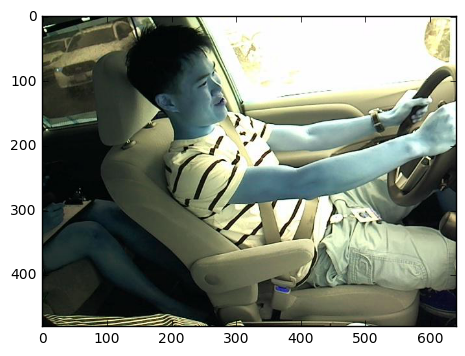

In [52]:
plt.imshow(image)

In [3]:
from keras.layers.convolutional import Convolution2D
last_convolution_index = [index for index, layer in enumerate(model.layers) if type(layer) is Convolution2D][-1]

In [4]:
last_convolution_index

17

In [6]:
from keras.models import Sequential
convolution_layers = model.layers[:last_convolution_index+1]
convolution_model = Sequential(convolution_layers)

In [7]:
fc_layers = model.layers[last_convolution_index + 1:]

In [13]:
train_batches = generator.flow_from_directory(
    'splits/unique_drivers/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)
validation_batches = generator.flow_from_directory(
    'splits/unique_drivers/valid',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 18047 images belonging to 10 classes.
Found 4377 images belonging to 10 classes.


In [17]:
from keras.utils.np_utils import to_categorical
train_labels = to_categorical(train_batches.classes)
validation_labels = to_categorical(validation_batches.classes)

In [18]:
train_batches.class_indices

{'c0': 0,
 'c1': 1,
 'c2': 2,
 'c3': 3,
 'c4': 4,
 'c5': 5,
 'c6': 6,
 'c7': 7,
 'c8': 8,
 'c9': 9}

In [ ]:
validation_features = convolution_model.predict_generator(validation_batches, validation_batches.samples, verbose=1)

   4/4377 [..............................] - ETA: 56273s

In [ ]:
%time train_features = convolution_model.predict_generator(train_batches, train_batches.nb_sample, verbose=True)

In [23]:
??DirectoryIterator

Object `DirectoryIterator` not found.


In [16]:
validation_batches

ImportError: cannot import name activity_l2

In [29]:
%%bash
split_name='sample'

rm -rf splits/$split_name
mkdir -p splits/$split_name/train
for obj_type in `ls train`; do
  mkdir -p splits/$split_name/train/$obj_type
  mkdir -p splits/$split_name/valid/$obj_type

  ls train/$obj_type | tail -n10 | xargs -I{} cp train/$obj_type/{} splits/$split_name/train/$obj_type
  ls train/$obj_type | tail -n20 | head -n10 | xargs -I{} cp train/$obj_type/{} splits/$split_name/valid/$obj_type
done

In [2]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator()
batch_size = 32
train_batches = generator.flow_from_directory(
    'splits/sample/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)
validation_batches = generator.flow_from_directory(
    'splits/sample/valid',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Found 100 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [3]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(weights='imagenet')

In [19]:
from keras.layers import Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
lr = 0.01
fc2 = vgg.get_layer('fc2').output
prediction = Dense(output_dim=10, activation='softmax', name='rediction')(fc2)
model = Model(input=vgg.input, output=prediction)
model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
for layer in model.layers[-2:]:
    layer.trainable = False

In [5]:
from keras.layers.convolutional import Convolution2D
layers = model.layers
last_conv_idx = [idx for idx,layer in enumerate(layers) if type(layer) == Convolution2D][-1]

In [6]:
from keras.models import Sequential
fc_layers = layers[last_conv_idx + 1:]
conv_layers = layers[:last_conv_idx + 1]
conv_model = Sequential(conv_layers)

In [7]:
from keras.utils.np_utils import to_categorical
val_classes = validation_batches.classes
train_classes = train_batches.classes
train_labels = to_categorical(train_classes)
val_labels = to_categorical(val_classes)

In [8]:
%time val_features = conv_model.predict_generator(validation_batches, validation_batches.nb_sample)

CPU times: user 6.34 s, sys: 976 ms, total: 7.32 s
Wall time: 6.01 s


In [9]:
%time train_features = conv_model.predict_generator(train_batches, train_batches.nb_sample)

CPU times: user 3.77 s, sys: 892 ms, total: 4.66 s
Wall time: 2.71 s


In [10]:
train_features.shape

(100, 512, 14, 14)

In [11]:
import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [79]:
cat ~/.theanorc

[global]
device = gpu
floatX = float32


In [13]:
model_path='/home/ubuntu/downloads/'
save_array(model_path + 'train_convlayer_features.bc', train_features)
save_array(model_path + 'valid_convlayer_features.bc', val_features)

In [14]:
train_features = load_array(model_path+'train_convlayer_features.bc')
val_features = load_array(model_path+'valid_convlayer_features.bc')

In [15]:
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [16]:
from keras.optimizers import RMSprop
opt = RMSprop(lr=0.00001, rho=0.7)

In [54]:
conv_layers[-1].output_shape[1:]

(512, 14, 14)

In [92]:
fc_layers

In [93]:
# set up the structure and copy the weights separately, otherwise naughty stuff happens
fc_model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(10, activation='softmax')
    ])

for l1,l2 in zip(fc_model.layers, fc_layers): l1.set_weights(proc_wgts(l2))

fc_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [95]:
train_features.shape, train_labels.shape, val_features.shape, val_labels.shape

((100, 512, 14, 14), (100, 10), (100, 512, 14, 14), (100, 10))

In [97]:
fc_model.fit(train_features, train_labels, nb_epoch=8, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 100 samples, validate on 100 samples
Epoch 1/8
100/100 [==============================] - 0s - loss: 1.5902 - acc: 0.8400 - val_loss: 2.1763 - val_acc: 0.1800
Epoch 2/8
100/100 [==============================] - 0s - loss: 1.1077 - acc: 0.9700 - val_loss: 2.1114 - val_acc: 0.2400
Epoch 3/8
100/100 [==============================] - 0s - loss: 0.7126 - acc: 0.9900 - val_loss: 2.1478 - val_acc: 0.2400
Epoch 4/8
100/100 [==============================] - 0s - loss: 0.4449 - acc: 0.9700 - val_loss: 1.9936 - val_acc: 0.3300
Epoch 5/8
100/100 [==============================] - 0s - loss: 0.2470 - acc: 1.0000 - val_loss: 1.9830 - val_acc: 0.3000
Epoch 6/8
100/100 [==============================] - 0s - loss: 0.1387 - acc: 1.0000 - val_loss: 2.0337 - val_acc: 0.2800
Epoch 7/8
100/100 [==============================] - 0s - loss: 0.0765 - acc: 1.0000 - val_loss: 2.0283 - val_acc: 0.3200
Epoch 8/8
100/100 [==============================] - 0s - loss: 0.0370 - acc: 1.0000 - val_loss: 2.0

In [32]:
train_features.shape

(100, 512, 14, 14)